## Postprocessing and plotting blocking detected in:
### CMIP6 models with the TM2D ABS / ANOM methods

In [1]:
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm
import sys
from time import sleep, perf_counter
#%load_ext line_profiler

/home/b/b382006/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Let's create the seasonal and annual frequency mean and save it in a netCDF file and then plot them

### if the files are created, move to the loading mean and plotting part

### Starting with reversal index

In [44]:
###

## REANALYSIS ERA5

In [64]:
###==ERA5
blocks_era5= xr.open_mfdataset('/work/bm1235/b382006/era5/block/ABS_Z500/BLOCKS-era5*.nc')

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [65]:
###==rename
blocks_era5=blocks_era5.rename({'longitude':'lon',
                       'latitude':'lat'
                       })
###===lon to 0 to 359
blocks_era5['lon']=blocks_era5['lon']+180
blocks_era5=blocks_era5.roll(lon=180)
blocks_era5

<xarray.Dataset>
Dimensions:   (time: 23376, lon: 360, lat: 181)
Coordinates:
  * time      (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2022-12-31
  * lon       (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat       (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
Data variables:
    Blocking  (time, lat, lon) int64 dask.array<chunksize=(11323, 181, 360), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 2.0.3 (https://...
    Conventions:               CF-1.6
    history:                   Sat Nov 18 23:31:51 2023: cdo -P 48 -b F32 day...
    frequency:                 day
    CDO:                       Climate Data Operators version 2.0.3 (https://...
    cdo_openmp_thread_number:  48

In [66]:
### select time period between 1979 and 2014 to compare with cmip6
yy1='1990'
yy2='2020'
sample=blocks_era5.sel(time=slice(yy1,yy2))
#sample

In [67]:
ntime_era5 = len(sample.time)
acc_era5 = sample.Blocking.sum(dim='time')/ntime_era5*100

In [68]:
### loading coordinates to interpolate
#feq_tmp=xr.open_dataset('/work/bm1235/b382006/regridding/icon/ngc2013_10km_to_1degree/block/ANO_Z500/Feq_BLOCKS-icon-ngc2013_'+sufix+'_ano.nc').load()
feq_tmp=xr.open_dataset('/work/bm1235/b382006/era5/block/ABS_Z500/Feq_BLOCKS-era5_'+sufix+'_1979-2014.nc').load()
sims_lon=feq_tmp.lon
sims_lat=feq_tmp.lat
###interpolate

In [69]:
new_lon=sims_lon
new_lat=sims_lat
acc_era5_reg=acc_era5.interp(lon=new_lon,lat=new_lat)

In [70]:
#acc_era5_reg

In [71]:
#acc_era5_reg.to_netcdf('/work/bm1235/b382006/era5/block/ABS_Z500/Feq_BLOCKS-era5.nc')

In [84]:
###BY SEASON

sufix='JJA'

if sufix == 'DJF': 
    season = [1,2,12] # winter
if sufix == 'MAM': 
    season = [3,4,5] # spring
if sufix == 'JJA': 
    season = [6,7,8] # summer
if sufix == 'SON': 
    season = [9,10,11] # winter

In [85]:
blocks_era5_sea = sample.sel(time=sample.time.dt.month.isin(season))
ntime_era5_sea = len(blocks_era5_sea.time)
acc_era5_sea = blocks_era5_sea.Blocking.sum(dim='time')/ntime_era5_sea*100
acc_era5_sea

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.DataArray 'Blocking' (lat: 181, lon: 360)>
dask.array<mul, shape=(181, 360), dtype=float64, chunksize=(181, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0

In [86]:
new_lon=sims_lon
new_lat=sims_lat
acc_era5_sea_reg=acc_era5_sea.interp(lon=new_lon,lat=new_lat)

In [87]:
###Save season as netcdf
acc_era5_sea_reg.to_netcdf('/work/bm1235/b382006/era5/block/ABS_Z500/Feq_BLOCKS-era5_'+sufix+'.nc')


## CMIP6 models

In [87]:
###==Loading 
# MPI-ESM1-2-HR, MPI-ESM1-2-LR, MIROC6,'MRI-ESM2-0','CESM2', 'CESM2-WACCM', 'EC-Earth3',"ACCESS-CM2"
model="ACCESS-CM2"
ens=['r10i1p1f1', 'r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1','r4i1p1f1', 'r5i1p1f1','r6i1p1f1','r7i1p1f1','r8i1p1f1','r9i1p1f1','r11i1p1f1']
iens=1
##historical
#inpath='/work/bm1235/b382006/cmip6/'+model+'/'+ens[10]+'/block/ABS_500'
#inpath='/scratch/b/b382006/cmip6/'+model+'/'+ens[iens]+'/block/ABS_500'
##scenarios
exper='ssp585'
inpath='/scratch/b/b382006/cmip6/'+exper+'/'+model+'/'+ens[iens]+'/block/ABS_500'

blocks_cmip6= xr.open_mfdataset(inpath+'/block_ABS-Z500_*')
#blocks_cmip6

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [88]:
#/scratch/b/b382006/cmip6/MIROC6/r1i1p1f1/block/ABS_500
#inpath
#blocks_cmip6

In [89]:
###===lon to 0 to 359
blocks_cmip6['lon']=blocks_cmip6['lon']+180
blocks_cmip6=blocks_cmip6.roll(lon=180)
#blocks_cmip6

In [95]:
###BY SEASON
sufix='JJA'

if sufix == 'DJF': 
    season = [1,2,12] # winter
if sufix == 'MAM': 
    season = [3,4,5] # spring
if sufix == 'JJA': 
    season = [6,7,8] # summer
if sufix == 'SON': 
    season = [9,10,11] # winter

blocks_cmip6_sea = blocks_cmip6.sel(time=blocks_cmip6.time.dt.month.isin(season))
ntime_cmip6_sea = len(blocks_cmip6_sea.time)
acc_cmip6_sea = blocks_cmip6_sea.Blocking.sum(dim='time')/ntime_cmip6_sea*100


In [96]:
### loading coordinates to interpolate
feq_icon_ngc2013_DJF=xr.open_dataset('/work/bm1235/b382006/era5/block/ABS_Z500/Feq_BLOCKS-era5_'+sufix+'.nc').load()
sims_lon=feq_icon_ngc2013_DJF.lon
sims_lat=feq_icon_ngc2013_DJF.lat
###interpolate
new_lon=sims_lon
new_lat=sims_lat
acc_cmip6_sea_reg=acc_cmip6_sea.interp(lon=new_lon,lat=new_lat)
#acc_cmip6_sea_reg.plot()

In [97]:
import os
import sys

###historical
#outpath='/work/bm1235/b382006/cmip6/'+model+'/'+ens[iens]+'/block/ABS_500/'
#outpath='/scratch/b/b382006/cmip6/'+model+'/'+ens[iens]+'/block/ABS_500'
###scenarios
outpath='/scratch/b/b382006/cmip6/'+exper+'/'+model+'/'+ens[iens]+'/block/ABS_500'

if not os.path.exists(outpath):
    os.makedirs(outpath)

In [98]:
###Save season as netcdf
acc_cmip6_sea_reg.to_netcdf(outpath+'/Feq_BLOCKS-cmip6_'+sufix+'.nc')
###/work/bm1235/b382006/cmip6/MPI-ESM1-2-HR/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc

In [99]:
outpath

'/scratch/b/b382006/cmip6/ssp585/ACCESS-CM2/r1i1p1f1/block/ABS_500'

## === Plotting bias

In [113]:
### Load the models and compute bias
sufix='DJF'

In [114]:
import numpy as np

def calc_agree(ensamble, cli):
    ############################
    ##===========Calculate diagreement
    #########################
    bias = ensamble - cli
    
    percent = 80
    threshold = percent / 100
    
    # Calculate the fraction of values greater than 0 and less than 0 along the first axis
    count1 = np.sum(bias > 0, axis=0) / bias.shape[0]
    count2 = np.sum(bias < 0, axis=0) / bias.shape[0]
    
    # Create the binary matrix where the condition is met
    binary = np.logical_or(count1 > threshold, count2 > threshold).astype(int)

    print("Calculated disagree")
    return binary

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets)**2).mean())

In [115]:
### dictonary with models
models=[
    'MRI-ESM2-0',
    'ACCESS-CM2',
    'EC-Earth3',    
    'MPI-ESM1-2-HR',
    'CESM2-WACCM', 
    'MIROC6',
    'MPI-ESM1-2-LR',
    'CESM2'
    ]

var='Blocking'
query = dict(
    source_id=models,  #Only choosing one model here
    member_id=['r10i1p1f1', 
               'r1i1p1f1', 
               'r2i1p1f1', 
               'r3i1p1f1', 
               'r4i1p1f1', 
               'r5i1p1f1', 
               'r6i1p1f1', 
               'r7i1p1f1', 
               'r8i1p1f1', 
               'r9i1p1f1',
               'r11i1p1f1']
    )

In [116]:
block_cmip6=[]
key = 'source_id' #set somewhere
for sid in query[key]:
    if sid=='CESM2':
        tmp = xr.open_dataset('/work/bm1235/b382006/cmip6/'+sid+'/'+query['member_id'][10]+'/block/ABS_500/Feq_BLOCKS-cmip6_'+sufix+'.nc').load()
    else:
        tmp = xr.open_dataset('/work/bm1235/b382006/cmip6/'+sid+'/'+query['member_id'][1]+'/block/ABS_500/Feq_BLOCKS-cmip6_'+sufix+'.nc').load()

    block_cmip6.append(tmp[var] )
    print(sid,'/work/bm1235/b382006/cmip6/'+sid+'/'+query['member_id'][1]+'/block/ABS_500/Feq_BLOCKS-cmip6_'+sufix+'.nc')
#    if sid=='MPI-ESM1-2-HR':
#        break


MRI-ESM2-0 /work/bm1235/b382006/cmip6/MRI-ESM2-0/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_DJF.nc
ACCESS-CM2 /work/bm1235/b382006/cmip6/ACCESS-CM2/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_DJF.nc
EC-Earth3 /work/bm1235/b382006/cmip6/EC-Earth3/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_DJF.nc
MPI-ESM1-2-HR /work/bm1235/b382006/cmip6/MPI-ESM1-2-HR/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_DJF.nc
CESM2-WACCM /work/bm1235/b382006/cmip6/CESM2-WACCM/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_DJF.nc
MIROC6 /work/bm1235/b382006/cmip6/MIROC6/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_DJF.nc
MPI-ESM1-2-LR /work/bm1235/b382006/cmip6/MPI-ESM1-2-LR/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_DJF.nc
CESM2 /work/bm1235/b382006/cmip6/CESM2/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_DJF.nc


In [117]:
###ERA5 climatology 1979-2014
block_era5=xr.open_dataset('/work/bm1235/b382006/era5/block/ABS_Z500/Feq_BLOCKS-era5_'+sufix+'_1979-2014.nc').load()
print('/work/bm1235/b382006/era5/block/ABS_Z500/Feq_BLOCKS-era5_'+sufix+'.nc')
#concatening
block_cmip6_ens=xr.concat(block_cmip6, "model")

### mean value
block_cmip6=block_cmip6_ens.mean(axis=0)

### subtracting
bias_block_ens = block_cmip6_ens - block_era5

### BIAS mean ensamble
bias_block = block_cmip6 - block_era5

/work/bm1235/b382006/era5/block/ABS_Z500/Feq_BLOCKS-era5_DJF.nc


/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [118]:
#block_cmip6_ens
#block_era5
#bias_block.lat

In [119]:
rmse_cmip6m1=rmse(block_cmip6_ens[0,...].sel(lat=slice(0,90)), block_era5.sel(lat=slice(0,90)))
rmse_cmip6m2=rmse(block_cmip6_ens[1,...].sel(lat=slice(0,90)), block_era5.sel(lat=slice(0,90)))
rmse_cmip6m3=rmse(block_cmip6_ens[2,...].sel(lat=slice(0,90)), block_era5.sel(lat=slice(0,90)))
rmse_cmip6m4=rmse(block_cmip6_ens[3,...].sel(lat=slice(0,90)), block_era5.sel(lat=slice(0,90)))
print(rmse_cmip6m1,rmse_cmip6m2,rmse_cmip6m3,rmse_cmip6m4)

<xarray.Dataset>
Dimensions:   ()
Data variables:
    Blocking  float64 0.4925 <xarray.Dataset>
Dimensions:   ()
Data variables:
    Blocking  float64 0.4399 <xarray.Dataset>
Dimensions:   ()
Data variables:
    Blocking  float64 0.4033 <xarray.Dataset>
Dimensions:   ()
Data variables:
    Blocking  float64 0.4426


In [120]:
### signicant test
binary = calc_agree(block_cmip6_ens,block_era5['Blocking'])
#binary

Calculated disagree


0
1
2
3
4
5
6
7
8


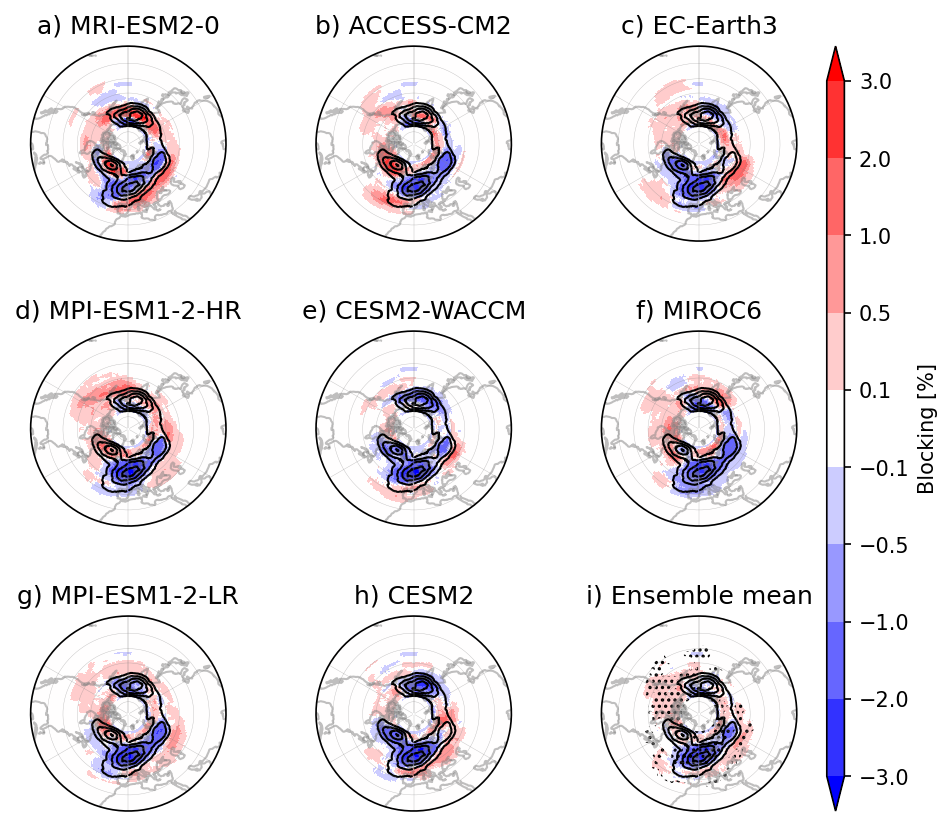

In [121]:
from mpl_toolkits.axes_grid1 import AxesGrid
from cartopy.mpl.geoaxes import GeoAxes
import matplotlib.path as mpath

#BIAS model - era5
#levs=[-8,-7,-6,-5,-4,-3,-2,-1,-0.5,0,0.5,1,2,3,4,5,6,7,8]
#cour=[6]
levs=[-3,-2,-1,-0.5,-0.1,0.1,0.5,1,2,3]
cour=np.arange(1,6,1)

lon_0 = -35.0
lat_0 =  70.0

### permanently circular
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

lonW=-180
lonE=180
latS=20
latN=90

#projection = ccrs.Orthographic(lon_0, lat_0)
projection = ccrs.NorthPolarStereo()

bounds = [(lonW, lonE, latS, latN)]

labels=["a)","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]


axes_class = (GeoAxes, dict(projection=projection))
fig = plt.figure(figsize=(7,7),dpi=150)
#fig.suptitle('d/dy(GH) [$1/100km$]', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(3, 3),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode

for i, ax in enumerate(axgr):
    print(i)
    if i<8:
        ax.coastlines(color='grey', alpha=0.5)
        ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2, color='gray', alpha=0.5, linestyle='-')
#        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey',alpha=0.30),zorder=20)
        ax.set_extent(*bounds, crs=ccrs.PlateCarree())
        p1 = bias_block_ens['Blocking'][i,:,:].plot(ax=ax,levels=levs, cmap='bwr', extend = 'both',transform=ccrs.PlateCarree(),add_colorbar=False)
        p2= block_era5['Blocking'].plot.contour(ax=ax, levels=cour, colors='k',linewidths=1, transform=ccrs.PlateCarree())
        ax.set_boundary(circle, transform= ax.transAxes)
        ax.set_title(labels[i]+' '+models[i], fontsize=12)
        axgr.cbar_axes[i].colorbar(p1,label='Blocking [%]')
    if i==8:
        ax.coastlines(color='grey', alpha=0.5)
        ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2, color='gray', alpha=0.5, linestyle='-')
#        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey',alpha=0.30),zorder=20)
        ax.set_extent(*bounds, crs=ccrs.PlateCarree())
        p1 = bias_block['Blocking'].plot(ax=ax,levels=levs, cmap='bwr', extend = 'both',transform=ccrs.PlateCarree(),add_colorbar=False)
        p2= block_era5['Blocking'].plot.contour(ax=ax, levels=cour, colors='k',linewidths=1, transform=ccrs.PlateCarree())
        ax.set_boundary(circle, transform= ax.transAxes)
        ax.set_title(labels[i]+' Ensemble mean', fontsize=12)
        axgr.cbar_axes[i].colorbar(p1,label='Blocking [%]')
        
        density=4
        ax.contourf(
        bias_block.lon, bias_block.lat, binary,
        transform=ccrs.PlateCarree(),
        colors='none',
        levels=[.5,1.5],
        hatches=[density*'.',density*'.'],
        )
    if i==9:
        ax.coastlines(color='grey', alpha=0.5)
        ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2, color='gray', alpha=0.5, linestyle='-')
#        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey',alpha=0.30),zorder=20)
        ax.set_extent(*bounds, crs=ccrs.PlateCarree())
#        p1 = bias_block_ens['Blocking'][i,:,:].plot(ax=ax,levels=levs, cmap='bwr', extend = 'both',transform=ccrs.PlateCarree(),add_colorbar=False)
        p2= block_era5['Blocking'].plot.contour(ax=ax, levels=cour, colors='k',linewidths=1, transform=ccrs.PlateCarree())
        ax.set_boundary(circle, transform= ax.transAxes)
        ax.set_title(labels[i]+' ERA5', fontsize=12)
        axgr.cbar_axes[i].colorbar(p1,label='Blocking [%]')

        
#axgr[-1].remove()
#fig.tight_layout()

    ## Save
plt.savefig('cmip6_block_bias-mean_'+sufix+'.jpg',bbox_inches='tight')
plt.show()

In [122]:
###==== Only ensemble mean

In [123]:
#filters and units
from scipy.ndimage import gaussian_filter
import cartopy.util as cutil

### BIAS mean ensamble
block_era5_fil = gaussian_filter(block_era5['Blocking'], sigma=1)
bias_block_fil = gaussian_filter(bias_block['Blocking'], sigma=0.5)

cblock_era5, clon = cutil.add_cyclic(block_era5_fil, block_era5.lon)
cbias_block, clon= cutil.add_cyclic(bias_block_fil, bias_block.lon)


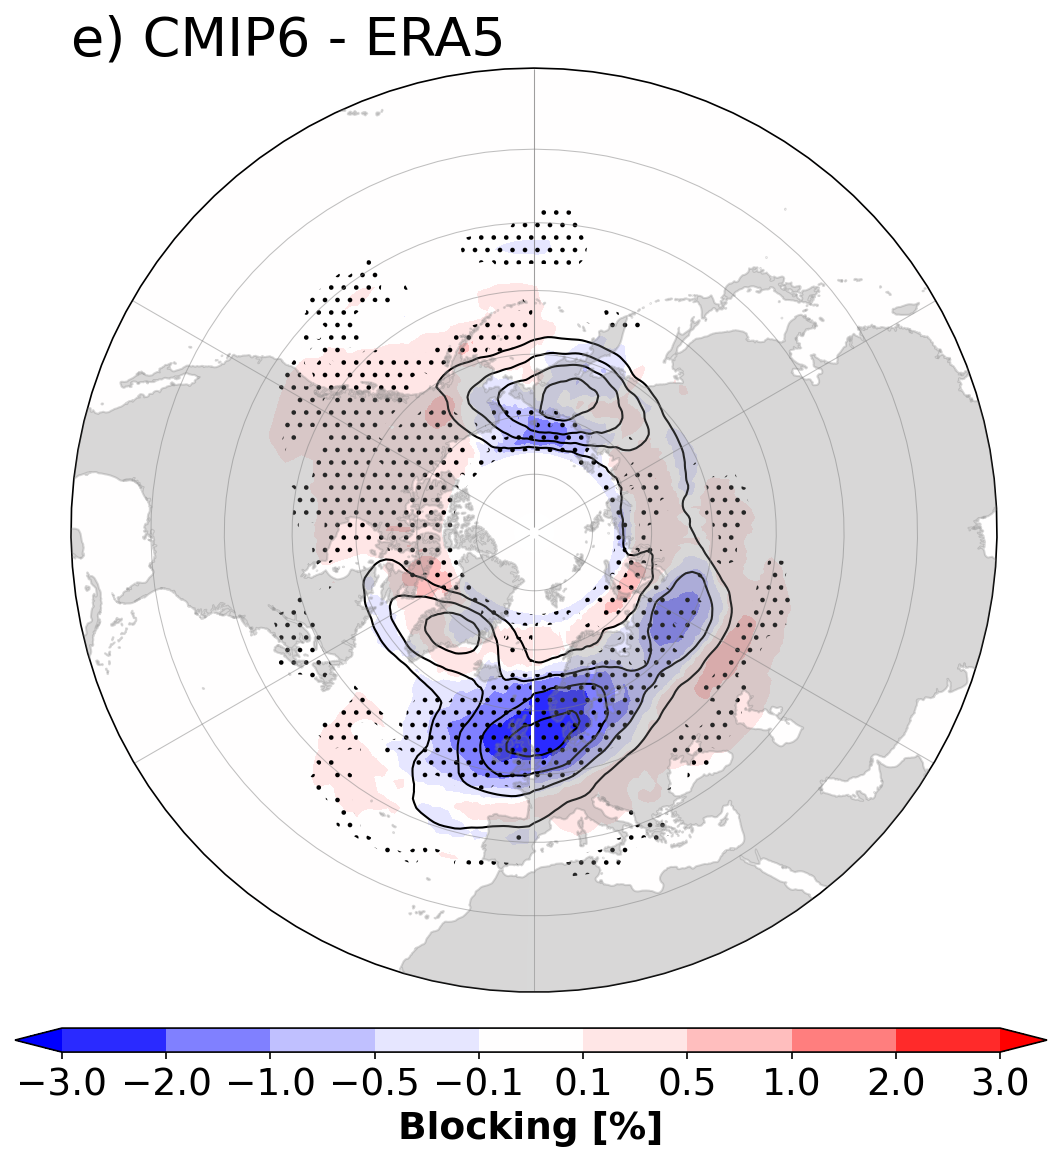

In [124]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

levs=[-3,-2,-1,-0.5,-0.1,0.1,0.5,1,2,3]
cour=np.arange(1,6,1)

lon_0 = -35.0
lat_0 =  70.0

labels=["e) CMIP6 - ERA5","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]

### Compute a circle in axes coordinates, which we can use as a boundary
### for the map. We can pan/zoom as much as we like - the boundary will be
### permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

##
#fig, ax1 = plt.subplots(1, 1, figsize=(8, 8),dpi=150, subplot_kw={'projection': ccrs.Orthographic(lon_0, lat_0)})
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8),dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})

#im1 =ax1.contourf(clon, bias_block.lat,bias_block_fil,levels=levs, cmap='bwr', extend = 'both',transform=ccrs.PlateCarree())
im1 =ax1.contourf(bias_block.lon, bias_block.lat,bias_block_fil, levels=levs, cmap='bwr', extend = 'both',transform=ccrs.PlateCarree())
ax1.contour(clon, bias_block.lat,cblock_era5,levels=cour,colors='k',linewidths=1, transform=ccrs.PlateCarree())
        
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey',alpha=0.30),zorder=20)
ax1.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
#ax1.coastlines(color='grey', alpha=1)
ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
ax1.set_title(labels[0],loc='left', fontsize=26)
ax1.set_boundary(circle, transform=ax1.transAxes)

       
density=2
ax1.contourf(
bias_block.lon, bias_block.lat, binary,
transform=ccrs.PlateCarree(),
colors='none',
levels=[.5,1.5],
hatches=[density*'.',density*'.'],
)

#ax1.set_title('CMIP6 - ERA5', fontsize=26)

###=========== [left, bottom, width, height].
cbaxes = fig.add_axes([0.08, 0.06, 0.86, 0.02])
cbar=fig.colorbar(im1,cax=cbaxes, orientation='horizontal',label='Blocking [%]')

cbar.ax.tick_params(labelsize=18) 
cbar.set_label(label='Blocking [%]',size=18,weight='bold') 
#fig.tight_layout()

## Save
plt.savefig('cmip6_block_bias_'+sufix+'_ens.jpg',bbox_inches='tight')


In [112]:
###Remove variables 
#import gc
#del blocks_era5
#del ntime_era5
#del acc_era5
#del blocks_era5_sea
#del ntime_era5_sea
#del acc_era5_sea
#gc.collect()

## Plot future changes

In [2]:
import numpy as np

def calc_agree(ensamble):
    ############################
    ##===========Calculate disagreement
    #########################              
    nm, nlat, nlon = np.shape(ensamble)
    percent = 80
    threshold = percent / 100
    
    # Calculate the fraction of values greater than 0 and less than 0 along the first axis
    count1 = np.sum(ensamble > 0, axis=0) / nm
    count2 = np.sum(ensamble < 0, axis=0) / nm
    
    # Create the binary matrix where the condition is met
    binary = np.logical_or(count1 > threshold, count2 > threshold).astype(int)

    print("Calculated disagree")
    return binary


In [3]:
#%lprun -f calc_agree calc_agree()

In [12]:
### Load the models and compute bias
sufix='JJA'

### dictonary with models
models=['MPI-ESM1-2-LR',
        'MPI-ESM1-2-HR',  
        'MIROC6',
        'MRI-ESM2-0',
        'CESM2',
        'CESM2-WACCM', 
        'EC-Earth3',
        'ACCESS-CM2']
var='Blocking'
query = dict(
    source_id=models,  #Only choosing one model here
    member_id=['r10i1p1f1', 
               'r1i1p1f1', 
               'r2i1p1f1', 
               'r3i1p1f1', 
               'r4i1p1f1', 
               'r5i1p1f1', 
               'r6i1p1f1', 
               'r7i1p1f1', 
               'r8i1p1f1', 
               'r9i1p1f1',
               'r11i1p1f1']
    )

In [13]:
block_pre=[]
key = 'source_id' #set somewhere
for sid in query[key]:
    if sid=='CESM2':
        tmp = xr.open_dataset('/work/bm1235/b382006/cmip6/'+sid+'/'+query['member_id'][10]+'/block/ABS_500/Feq_BLOCKS-cmip6_'+sufix+'.nc').load()
    else:
        tmp = xr.open_dataset('/work/bm1235/b382006/cmip6/'+sid+'/'+query['member_id'][1]+'/block/ABS_500/Feq_BLOCKS-cmip6_'+sufix+'.nc').load()

    block_pre.append(tmp[var] )
    print(sid,'/work/bm1235/b382006/cmip6/'+sid+'/'+query['member_id'][1]+'/block/ABS_500/Feq_BLOCKS-cmip6_'+sufix+'.nc')
#    if sid=='MPI-ESM1-2-HR':
#        break


MPI-ESM1-2-LR /work/bm1235/b382006/cmip6/MPI-ESM1-2-LR/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
MPI-ESM1-2-HR /work/bm1235/b382006/cmip6/MPI-ESM1-2-HR/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
MIROC6 /work/bm1235/b382006/cmip6/MIROC6/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
MRI-ESM2-0 /work/bm1235/b382006/cmip6/MRI-ESM2-0/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
CESM2 /work/bm1235/b382006/cmip6/CESM2/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
CESM2-WACCM /work/bm1235/b382006/cmip6/CESM2-WACCM/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
EC-Earth3 /work/bm1235/b382006/cmip6/EC-Earth3/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
ACCESS-CM2 /work/bm1235/b382006/cmip6/ACCESS-CM2/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc


In [14]:
### future climate
block_fut=[]
key = 'source_id' #set somewhere
for sid in query[key]:
    if sid=='CESM2':
        tmp = xr.open_dataset('/scratch/b/b382006/cmip6/ssp585/'+sid+'/'+query['member_id'][10]+'/block/ABS_500/Feq_BLOCKS-cmip6_'+sufix+'.nc').load()
    else:
        tmp = xr.open_dataset('/scratch/b/b382006/cmip6/ssp585/'+sid+'/'+query['member_id'][1]+'/block/ABS_500/Feq_BLOCKS-cmip6_'+sufix+'.nc').load()

    block_fut.append(tmp[var] )
    print(sid,'/scratch/b/b382006/cmip6/ssp585/'+sid+'/'+query['member_id'][1]+'/block/ABS_500/Feq_BLOCKS-cmip6_'+sufix+'.nc')
#    if sid=='MPI-ESM1-2-HR':
#        break


MPI-ESM1-2-LR /scratch/b/b382006/cmip6/ssp585/MPI-ESM1-2-LR/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
MPI-ESM1-2-HR /scratch/b/b382006/cmip6/ssp585/MPI-ESM1-2-HR/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
MIROC6 /scratch/b/b382006/cmip6/ssp585/MIROC6/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
MRI-ESM2-0 /scratch/b/b382006/cmip6/ssp585/MRI-ESM2-0/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
CESM2 /scratch/b/b382006/cmip6/ssp585/CESM2/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
CESM2-WACCM /scratch/b/b382006/cmip6/ssp585/CESM2-WACCM/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
EC-Earth3 /scratch/b/b382006/cmip6/ssp585/EC-Earth3/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc
ACCESS-CM2 /scratch/b/b382006/cmip6/ssp585/ACCESS-CM2/r1i1p1f1/block/ABS_500/Feq_BLOCKS-cmip6_JJA.nc


In [15]:
#concatening
block_pre_ens=xr.concat(block_pre, "model")

### mean value
block_pre=block_pre_ens.mean(axis=0)

#concatening
block_fut_ens=xr.concat(block_fut, "model")

### mean value
block_fut=block_fut_ens.mean(axis=0)

### subtracting
chgs_block_ens = block_fut_ens - block_pre_ens

### change mean ensamble
chgs_block = block_fut - block_pre

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [16]:
### signicant test
binary = calc_agree(chgs_block_ens)

Calculated disagree


In [17]:
#chgs_block_ens[:,1,1]
binary
#print(b,count1,count2,p1,p2)
#b=chgs_block_ens[:,140,180]
#b.plot()

#block_pre_ens[:,140,180].plot()

<xarray.DataArray 'Blocking' (lat: 180, lon: 360)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [18]:
#filters and units
from scipy.ndimage import gaussian_filter
import cartopy.util as cutil

### BIAS mean ensamble
block_pre_fil = gaussian_filter(block_pre, sigma=1)
chgs_block_fil = gaussian_filter(chgs_block, sigma=0.5)

cblock_pre, clon = cutil.add_cyclic(block_pre_fil, block_pre.lon)
cchgs_block, clon= cutil.add_cyclic(chgs_block_fil, chgs_block.lon)

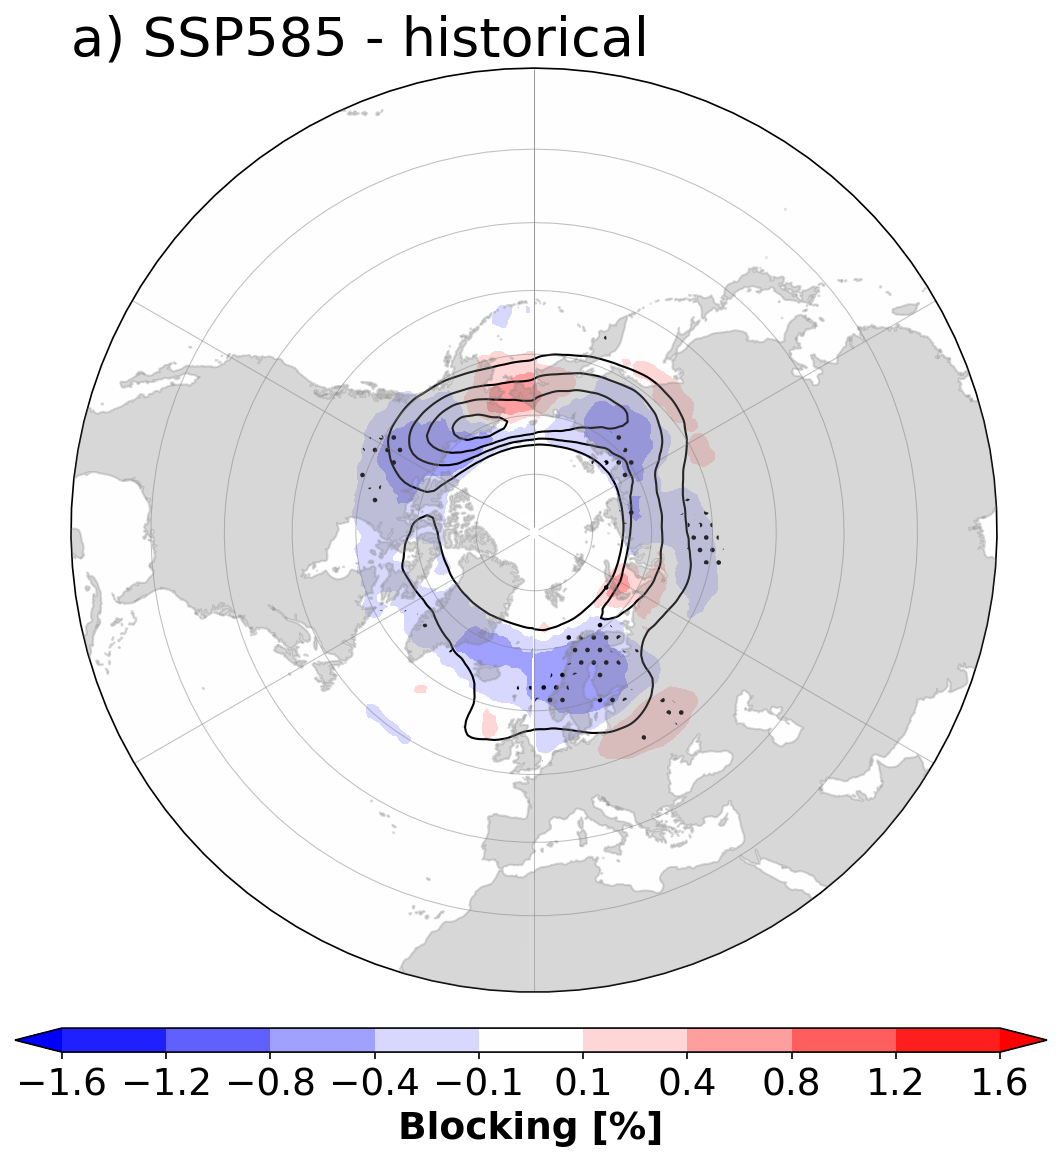

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

levs=[-1.6,-1.2,-0.8,-0.4,-0.1,0.1,0.4,0.8,1.2,1.6]
cour=np.arange(1,6,1)

lon_0 = -35.0
lat_0 =  70.0

labels=["a) SSP585 - historical","b)","c)","d)","e)","f)","g)","h)","i)","j)","k)","l)"]

### Compute a circle in axes coordinates, which we can use as a boundary
### for the map. We can pan/zoom as much as we like - the boundary will be
### permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

##
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8),dpi=150, subplot_kw={'projection': ccrs.NorthPolarStereo()})

im1 =ax1.contourf(chgs_block.lon, chgs_block.lat,chgs_block_fil, levels=levs, cmap='bwr', extend = 'both',transform=ccrs.PlateCarree())
ax1.contour(clon, chgs_block.lat,cblock_pre,levels=cour,colors='k',linewidths=1, transform=ccrs.PlateCarree())
        
ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='grey',alpha=0.30),zorder=20)
ax1.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
#ax1.coastlines(color='grey', alpha=1)
ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
ax1.set_title(labels[0],loc='left', fontsize=26)
ax1.set_boundary(circle, transform=ax1.transAxes)

density=2
ax1.contourf(
chgs_block.lon, chgs_block.lat, binary,
transform=ccrs.PlateCarree(),
colors='none',
levels=[.5,1.5],
hatches=[density*'.',density*'.'],
)

#ax1.set_title('CMIP6 - ERA5', fontsize=26)

###=========== [left, bottom, width, height].
cbaxes = fig.add_axes([0.08, 0.06, 0.86, 0.02])
cbar=fig.colorbar(im1,cax=cbaxes, orientation='horizontal',label='Blocking [%]')
cbar.ax.tick_params(labelsize=18) 
cbar.set_label(label='Blocking [%]',size=18,weight='bold') 
#fig.tight_layout()

## Save
plt.savefig('cmip6_block_ssp585_'+sufix+'_ens.jpg',bbox_inches='tight')